In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

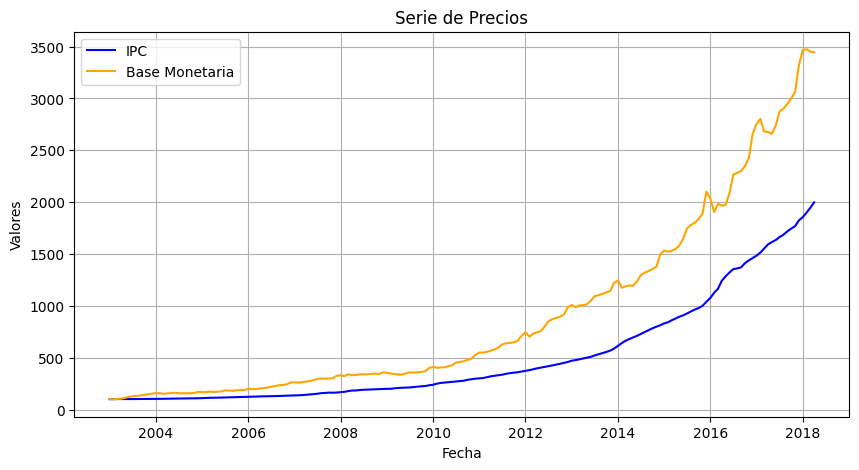

In [5]:
df = pd.read_excel('./Precios_y_Dinero.xlsx', sheet_name='precios_y_dinero')
df['MMYY'] = pd.to_datetime(df['MMYY'])
df.set_index('MMYY', inplace=True)

#agregar al grafico de arriba la base monetaria que es la columna M
def graficar_serie_con_base(df, titulo):
    """Grafica una serie de tiempo con base monetaria."""
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['IPC'], color='blue', label='IPC')
    plt.plot(df.index, df['M '], color='orange', label='Base Monetaria')
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid()
    plt.show()

graficar_serie_con_base(df, 'Serie de Precios')


### Parecería que hay correlación entre el aumento del IPC y la base monetaria.

### Ejercicio 2. Verificar el orden de integracion de la serie de precios y de la base monetaria usando Dickey-Fuller aumentado.
### El test de Dickey_Fuller_aumentado
### Si el estadístico es menor a los valores críticos entonces rechazo H0

In [6]:

from statsmodels.tsa.stattools import adfuller 
def test_dickey_fuller(series):
    """Realiza la prueba de Dickey-Fuller aumentado."""
    result = adfuller(series, autolag='AIC')
    print(f'Estadístico ADF: {result[0]}')
    print(f'Valor p: {result[1]}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'  {key}: {value}')

test_dickey_fuller(df['IPC'])


Estadístico ADF: 5.546743482308888
Valor p: 1.0
Valores críticos:
  1%: -3.4680615871598537
  5%: -2.8781061899535128
  10%: -2.5756015922004134


### En el test de Df bajo la H0 la serie es No Estacionaria

### Aca se puede ver que el p-value es recontra positivo y el estadísitco es positivo, por lo tanto NRH0 y la serie es No estacionaria

### Tomamos las primeras diferencia a ver que pasa

In [7]:
df['dIPC']=df['IPC'].diff()

test_dickey_fuller(df['dIPC'].dropna())


Estadístico ADF: 0.32708478876600483
Valor p: 0.9785535607817415
Valores críticos:
  1%: -3.4685016947910636
  5%: -2.8782983668563396
  10%: -2.57570415906989


### En teoría las primeras diferencias sigen dando que el IPC es No estacionario. En general es el Log().diff() y eso da que es estacionario

In [8]:
df['log_dIPC']=np.log(df['IPC']).diff()
test_dickey_fuller(df['log_dIPC'].dropna())


Estadístico ADF: -4.454206536532711
Valor p: 0.00023770031249084738
Valores críticos:
  1%: -3.467004502498507
  5%: -2.8776444997243558
  10%: -2.575355189707274


### veamos que pasa con las segundas diferencias

In [9]:
df['ddIPC']=df['dIPC'].diff()
test_dickey_fuller(df['ddIPC'].dropna())


Estadístico ADF: -7.368282328173165
Valor p: 9.113361917991526e-11
Valores críticos:
  1%: -3.4685016947910636
  5%: -2.8782983668563396
  10%: -2.57570415906989


### Aca vemos que el I(2) es el que corresponde

### Ejercicio 3. Integramos y validamos con ADF pero la serie m

In [10]:

test_dickey_fuller(df['M '])

Estadístico ADF: 3.841784647355517
Valor p: 1.0
Valores críticos:
  1%: -3.469413468959902
  5%: -2.8786964197028295
  10%: -2.5759166089965397


### Nuevamente el test DF es una prueba de raices unitarias, 
- H0: tiene una raiz unitaria, por lo tanto es NO estacionario. 
- H1: es estacionario. 
- Si el estadístico es mayor al VC entonces NRH0 y por lo tanto es No estacionaria

In [11]:
### Ahora tomo las primeras diferencias a ver que pasa. 

df['dm']=df['M '].diff()

test_dickey_fuller(df['dm'].dropna())

Estadístico ADF: 0.8409495074661356
Valor p: 0.9922692241359652
Valores críticos:
  1%: -3.469648263987657
  5%: -2.878798906308495
  10%: -2.5759713094779593


### Sigue siendo No estacionaria

In [12]:
df['ddm']=df['dm'].diff()

test_dickey_fuller(df['ddm'].dropna())

Estadístico ADF: -9.814175876227758
Valor p: 5.554205778300402e-17
Valores críticos:
  1%: -3.469648263987657
  5%: -2.878798906308495
  10%: -2.5759713094779593


### Ahora si, podemos ver que como RH0 dado que el estadísitico esta mas a la iza del VC y el p-value es significativo es I(2)

## Ejercicio 4. Generamos la inflación (tasa de crecimiento del IPc y la tasa de crecimiento de m)

### Esto es como siempre, log().diff(), es decir tomamos el logaritmo y la diferencia de ello. que es lo mismo que  ln((v1-v0)/v0)

In [13]:

# Aca hay que tener en cuenta que los valores se generan "normales" en general cuando se quiere
# ver la tasa se expresa en porcentuals, por lo tanto hay que multiplicar por 100
df['inflacion']=np.log(df['IPC']).diff()
df['crec_m']=np.log(df['M ']).diff()

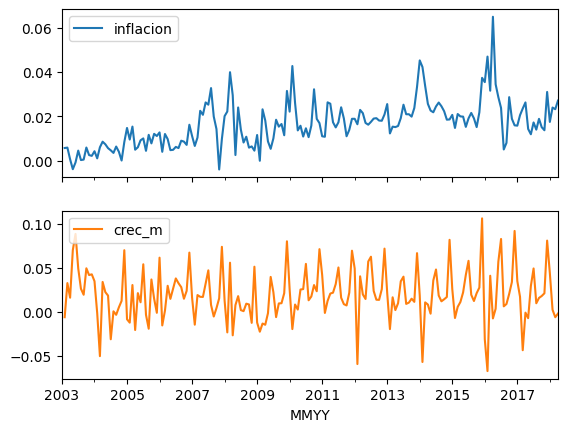

In [14]:
### graficamos inflacion y crec_m
df[['inflacion','crec_m']].plot(subplots=True)
plt.show()


In [17]:
#Aca parecie que inflacion tiene una tendencia asi que hacemos unas cuentas: 

n = len(df["inflacion"].dropna())
print("Media primer mitad:", df["inflacion"].iloc[:n//2].mean())
print("Media segunda mitad:", df["inflacion"].iloc[n//2:].mean())

Media primer mitad: 0.011060201463234708
Media segunda mitad: 0.021498556143082593


In [18]:

print("*******Inflacion********")
test_dickey_fuller(df['inflacion'].dropna())
print("******Crecimiento de la base monetaria*****")
test_dickey_fuller(df['crec_m'].dropna())

*******Inflacion********
Estadístico ADF: -4.454206536532711
Valor p: 0.00023770031249084738
Valores críticos:
  1%: -3.467004502498507
  5%: -2.8776444997243558
  10%: -2.575355189707274
******Crecimiento de la base monetaria*****
Estadístico ADF: -3.123289930138144
Valor p: 0.024876955171343387
Valores críticos:
  1%: -3.4698858990744115
  5%: -2.8789026251889647
  10%: -2.5760266680839004


In [25]:
from arch.unitroot import DFGLS
print("*******Inflacion********")
dfgls_infl = DFGLS(df['inflacion'].dropna())
print(dfgls_infl.summary())
print("******Crecimiento de la base monetaria*****")
dfgls_crecm = DFGLS(df['crec_m'].dropna())
print(dfgls_crecm.summary())



*******Inflacion********
      Dickey-Fuller GLS Results      
Test Statistic                 -3.194
P-value                         0.001
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -2.68 (1%), -2.06 (5%), -1.74 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
******Crecimiento de la base monetaria*****
      Dickey-Fuller GLS Results      
Test Statistic                 -1.145
P-value                         0.237
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -2.68 (1%), -2.06 (5%), -1.75 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


#### Aca se puede ver que es I(0) porque el p-value es significativo

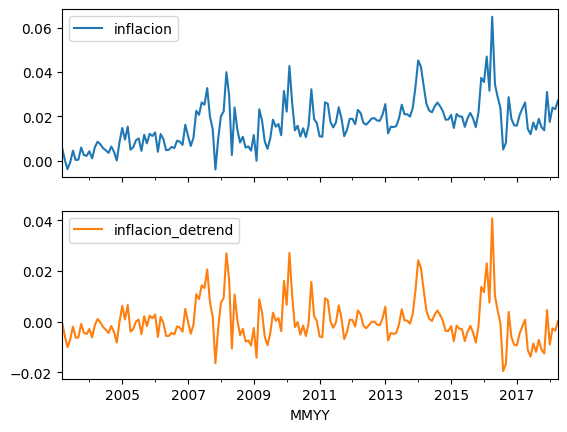

In [36]:
from scipy import signal
df["inflacion_detrend"]=np.nan
serie =df['inflacion'].dropna()

df.loc[serie.index,"inflacion_detrend"]=signal.detrend(serie.values)
df = df.dropna()
df.head()
df.describe()   
## graficamos de nuevo
df[['inflacion','inflacion_detrend']].plot(subplots=True)
plt.show()  

In [37]:
## corremos el test de df con la serie sin tendencia
print("*******Inflacion detrended********")
test_dickey_fuller(df['inflacion_detrend'].dropna())


*******Inflacion detrended********
Estadístico ADF: -7.7141903696141485
Valor p: 1.2407930165183226e-11
Valores críticos:
  1%: -3.467004502498507
  5%: -2.8776444997243558
  10%: -2.575355189707274


### Ejercicio 5. Muestre el correlograma y el correlograma parcial de la serie inflacion. 

In [14]:
def plot_acf_pacf(series, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    plt.show()

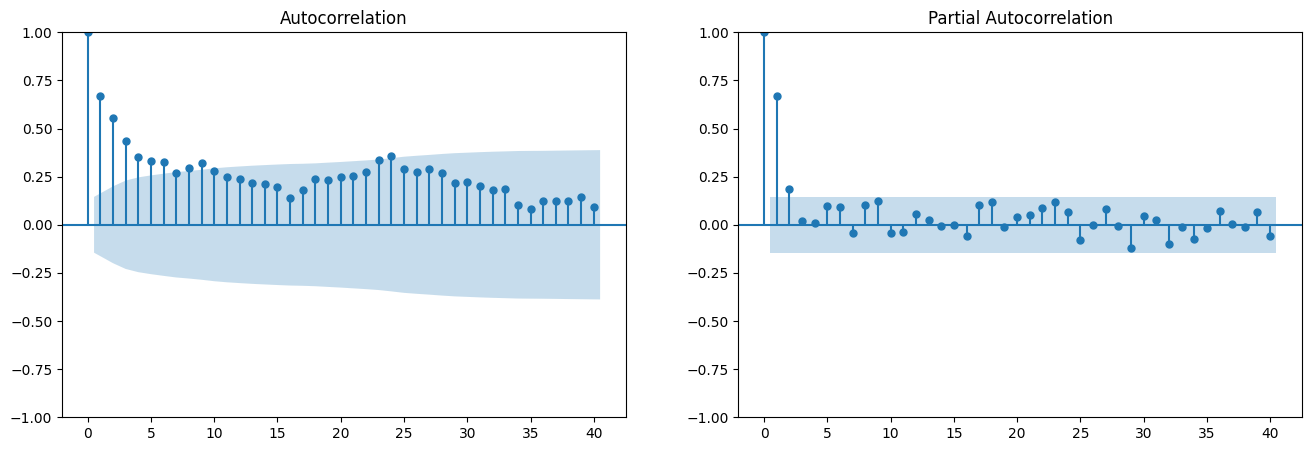

In [15]:
plot_acf_pacf(df['inflacion'].dropna())

### Con la función de autocorrelacion lo que vemos es podria tener una leve tendencia ya que decale lentamente (MA?)
### con la de autocorrelacion parcial lo que se ve es si es un un AR puro, donde se corta es el AR, en este caso es un AR(2) por lo tanto, la inflación es un proceso autoregresivo de orden 2. También, podria ser un AR(1) porque es un 95% si subimos el intervalo quedaría AR1


In [16]:
df

,IPC,M,M_en_ARS,dIPC,log_dIPC,ddIPC,dm,ddm,inflacion,crec_m
MMYY,,,,,,,,,,
2003-01-01,100.000000,100.000000,2.960992e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-01,100.566796,99.359830,2.942037e+04,0.566796,0.005652,NaN,-0.640170,NaN,0.005652,-0.006422
2003-03-01,101.155116,102.628052,3.038808e+04,0.588320,0.005833,0.021524,3.268222,3.908392,0.005833,0.032363
2003-04-01,101.212513,104.258927,3.087099e+04,0.057397,0.000567,-0.530923,1.630876,-1.637346,0.000567,0.015766
2003-05-01,100.817908,111.804321,3.310517e+04,-0.394605,-0.003906,-0.452002,7.545393,5.914518,-0.003906,0.069873
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1823.417965,3318.684071,9.826597e+05,55.546075,0.030936,31.566114,257.268315,194.341304,0.030936,0.080691
2018-01-01,1855.461867,3467.352097,1.026680e+06,32.043902,0.017421,-23.502173,148.668025,-108.600289,0.017421,0.043823
2018-02-01,1900.346122,3474.208773,1.028710e+06,44.884256,0.023902,12.840354,6.856677,-141.811349,0.023902,0.001976


### Ejercicio 6. Repetir para crec_m

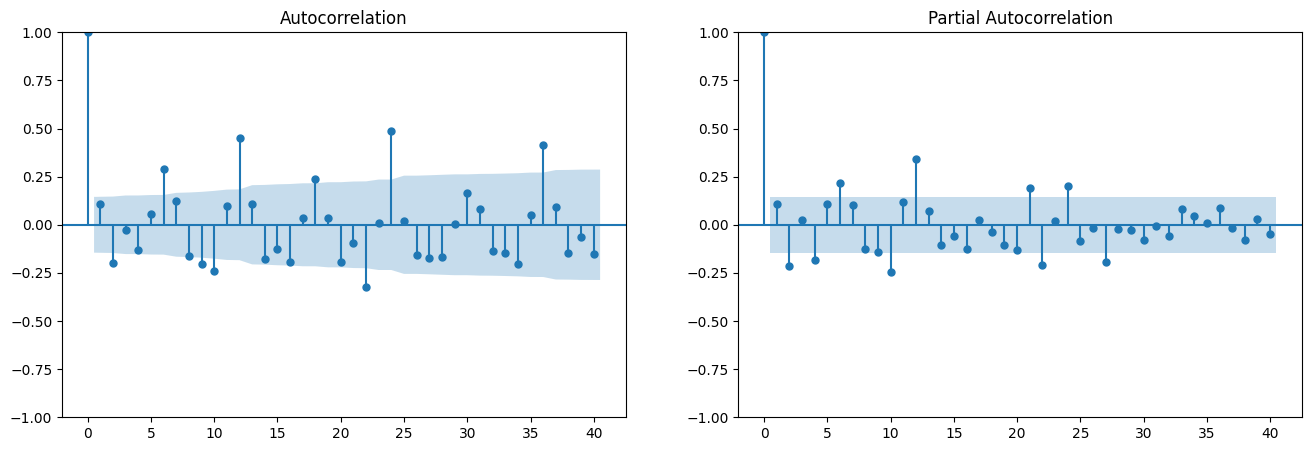

In [17]:
plot_acf_pacf(df['crec_m'].dropna())

### Aca se puede ver cierta estacionalidad, En el mes 7 y 1 hay picos (MA 12 O 7)?
### Luego tambien se observa que es un posible AR(1)

### Ejercicio 7. 